# FLUX
## Black Forest Labs

Sources :  
https://huggingface.co/black-forest-labs   
https://github.com/black-forest-labs/flux?tab=readme-ov-file   
https://www.mlexpert.io/blog/flux-1-dev   

In [3]:
import os
import gc
import random
from datetime import datetime
from dotenv import load_dotenv
from huggingface_hub import HfApi, HfFolder
from diffusers import FluxPipeline
import torch
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load environment variables from .env file
load_dotenv()

# Obtain the authentication token from the environment variables
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")
if not HUGGINGFACE_TOKEN:
    raise ValueError("The Hugging Face token is not defined in the .env file.")

# Authenticate with Hugging Face
def authenticate():
    api = HfApi()
    try:
        api.whoami(token=HUGGINGFACE_TOKEN)  # Vérifier la validité du token
        HfFolder.save_token(HUGGINGFACE_TOKEN)  # Sauvegarder le token pour une utilisation future
        print("Authentication successful.")
    except Exception as e:
        print(f"Authentication error : {e}")
        raise

# Authenticate the user
authenticate()

Authentication successful.


In [4]:

# Libération intiale de la mémoire
def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()
    print("Mémoire libérée")

clear_memory()

Mémoire libérée


In [5]:
# Hugging Face model selection
model_dev = "black-forest-labs/FLUX.1-dev"         # licence = Non-Commercial License 
model_schnell = "black-forest-labs/FLUX.1-schnell" # licence = apache-2.0

# Choix du model
model_id = model_dev
print("Selected Model:",model_id)

Selected Model: black-forest-labs/FLUX.1-dev


In [6]:
# Load the model (or dowanload it if it's the first time) 
pipe = FluxPipeline.from_pretrained(model_id, torch_dtype=torch.bfloat16)
# Move it to the GPU
pipe.to("cuda") # pipe.enable_model_cpu_offload() #save some VRAM by offloading the model to CPU. Remove this if you have enough GPU power


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


FluxPipeline {
  "_class_name": "FluxPipeline",
  "_diffusers_version": "0.30.2",
  "_name_or_path": "black-forest-labs/FLUX.1-dev",
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "T5TokenizerFast"
  ],
  "transformer": [
    "diffusers",
    "FluxTransformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [7]:
# src

def create_exploration_folder(save_folder):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    exploration_folder = os.path.join(save_folder, timestamp)
    os.makedirs(exploration_folder)
    for subfolder in ["exploration_images", "inference_steps_images", "guidance_images"]:
        os.makedirs(os.path.join(exploration_folder, subfolder))
    return exploration_folder

def generate_images(
    prompt: str,
    guidance_scale: float = 3.5, # 3.5
    n_steps: int = 30, # 30
    lora_scale: float = 1.0,
    n_images: int = 1,
    seed: int = None,
    width=128,
    height=128
):
    images = []
    seeds = []
    # Si aucune seed n'est spécifiée, en génère une
    if seed is None:
        seed = random.randint(0, 2**32 - 1)
        
    for i in tqdm(range(n_images), desc="Generating images"):
        batch = pipe(
            prompt=prompt,
            width=width,
            height=width,
            guidance_scale=guidance_scale,
            output_type="pil",
            num_inference_steps=n_steps,
            max_sequence_length=512,
            num_images_per_prompt=1,
            generator=torch.Generator("cpu").manual_seed(seed),
            joint_attention_kwargs={"scale": lora_scale},
        ).images
        images.extend(batch)
        seeds.append(seed)

        # Change la seed pour chaque image si nécessaire
        seed += 1
        
        if (i + 1) % clear_every == 0:
            clear_memory()
    return images, seeds

def save_images(images, titles, save_subfolder):
    for img, title in zip(images, titles):
        save_path = os.path.join(save_subfolder, f"{title}.png")
        img.save(save_path)
        print(f"Image sauvegardée : {save_path}")
    print(f"Nombre total d'images générées et sauvegardées : {len(images)}")
    print(f"Nombre approximatif de tokens dans le prompt : {len(prompt.split())}")

def plot_images(images, titles, n_cols=2): # n_cols = nb de colonne par ligne
    n_images = len(images)
    n_rows = (n_images - 1) // n_cols + 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    axes = axes.flatten()

    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title)

    for i in range(n_images, n_rows * n_cols):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
# Définir le dossier de sauvegarde
save_folder = r"E:\DATABASE\Images"
os.makedirs(save_folder, exist_ok=True)
    # Créer le dossier d'exploration
exploration_folder = create_exploration_folder(save_folder)

# Définition du prompt
prompt = "In the foreground a meadow covered with poppies, and a beautiful white house, before in the background a blue sea and a clear blue sky. Uses a Hayao Miyazaki style. A father plays with his child"
# Définir combien d'images générer avant de libérer la mémoire
clear_every = 2  # Vous pouvez ajuster cette valeur en fonction de la mémoire disponible

Generating images:   0%|                                                                         | 0/4 [00:00<?, ?it/s]C:\Users\Simon\anaconda3\envs\ia\Lib\site-packages\transformers\models\clip\modeling_clip.py:540: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/30 [00:00<?, ?it/s]

Generating images:  25%|███████████████▎                                             | 1/4 [48:19<2:24:57, 2899.23s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Generating images:  50%|█████████████████████████████▌                             | 2/4 [1:36:39<1:36:39, 2899.57s/it]

Mémoire libérée


  0%|          | 0/30 [00:00<?, ?it/s]

Generating images:  75%|█████████████████████████████████████████████▊               | 3/4 [2:25:00<48:20, 2900.54s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Generating images: 100%|█████████████████████████████████████████████████████████████| 4/4 [3:13:23<00:00, 2900.88s/it]

Mémoire libérée


Image sauvegardée : E:\DATABASE\Images\20250117_183923\exploration_images\seed_69059995.png
Image sauvegardée : E:\DATABASE\Images\20250117_183923\exploration_images\seed_69059996.png
Image sauvegardée : E:\DATABASE\Images\20250117_183923\exploration_images\seed_69059997.png
Image sauvegardée : E:\DATABASE\Images\20250117_183923\exploration_images\seed_69059998.png
Nombre total d'images générées et sauvegardées : 4
Nombre approximatif de tokens dans le prompt : 36


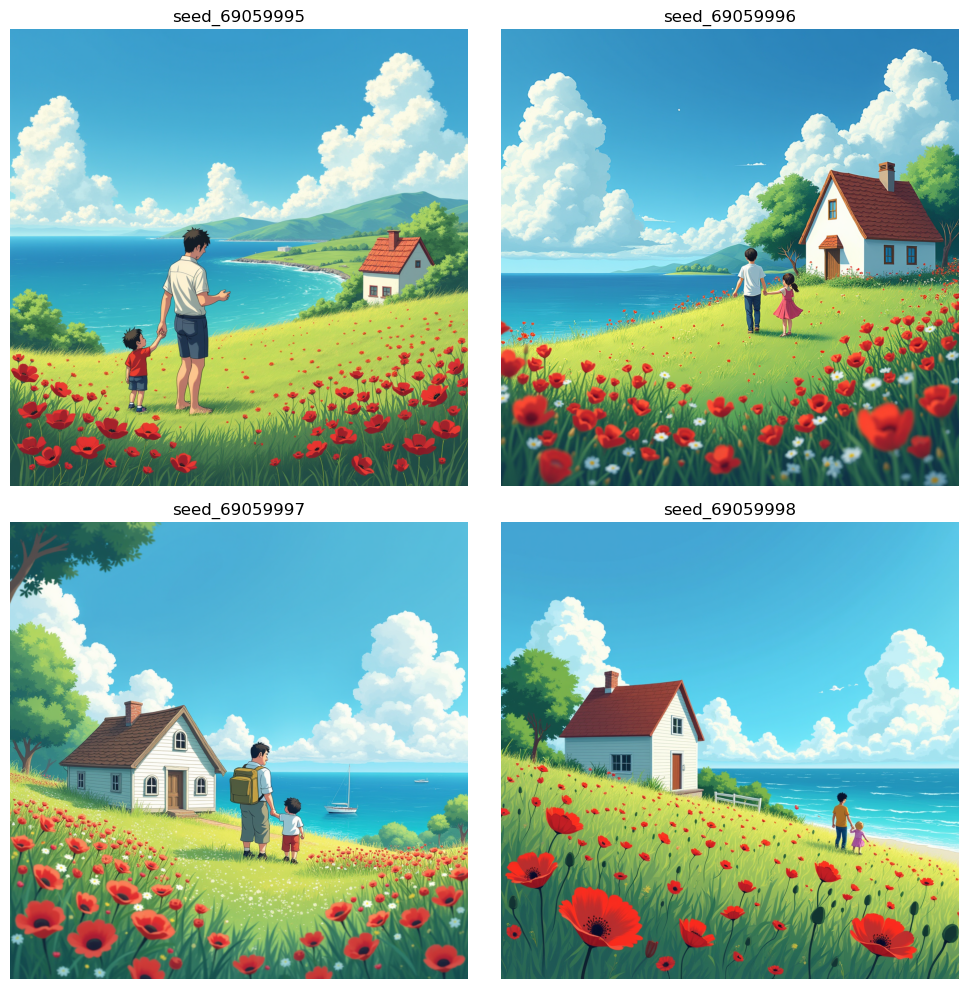

Mémoire libérée
liste des seeds: [69059995, 69059996, 69059997, 69059998]


In [9]:
# Étape 1 : Génération d'images avec différentes seeds
n_images = 4
images, seeds = generate_images(prompt, n_images=n_images, width=1024, height=768)
save_images(images, [f"seed_{seed}" for seed in seeds], os.path.join(exploration_folder, "exploration_images"))
plot_images(images, [f"seed_{seed}" for seed in seeds])
clear_memory()
print('liste des seeds:',seeds)

selected_seed: 69059995


Generating images:   0%|                                                                         | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Generating images:   0%|                                                                         | 0/1 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating images:   0%|                                                                         | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Generating images: 100%|███████████████████████████████████████████████████████████████| 1/1 [48:16<00:00, 2896.18s/it]


Image sauvegardée : E:\DATABASE\Images\20250117_183923\inference_steps_images\seed_69059995_inference_20.png
Image sauvegardée : E:\DATABASE\Images\20250117_183923\inference_steps_images\seed_69059995_inference_25.png
Image sauvegardée : E:\DATABASE\Images\20250117_183923\inference_steps_images\seed_69059995_inference_30.png
Nombre total d'images générées et sauvegardées : 3
Nombre approximatif de tokens dans le prompt : 36


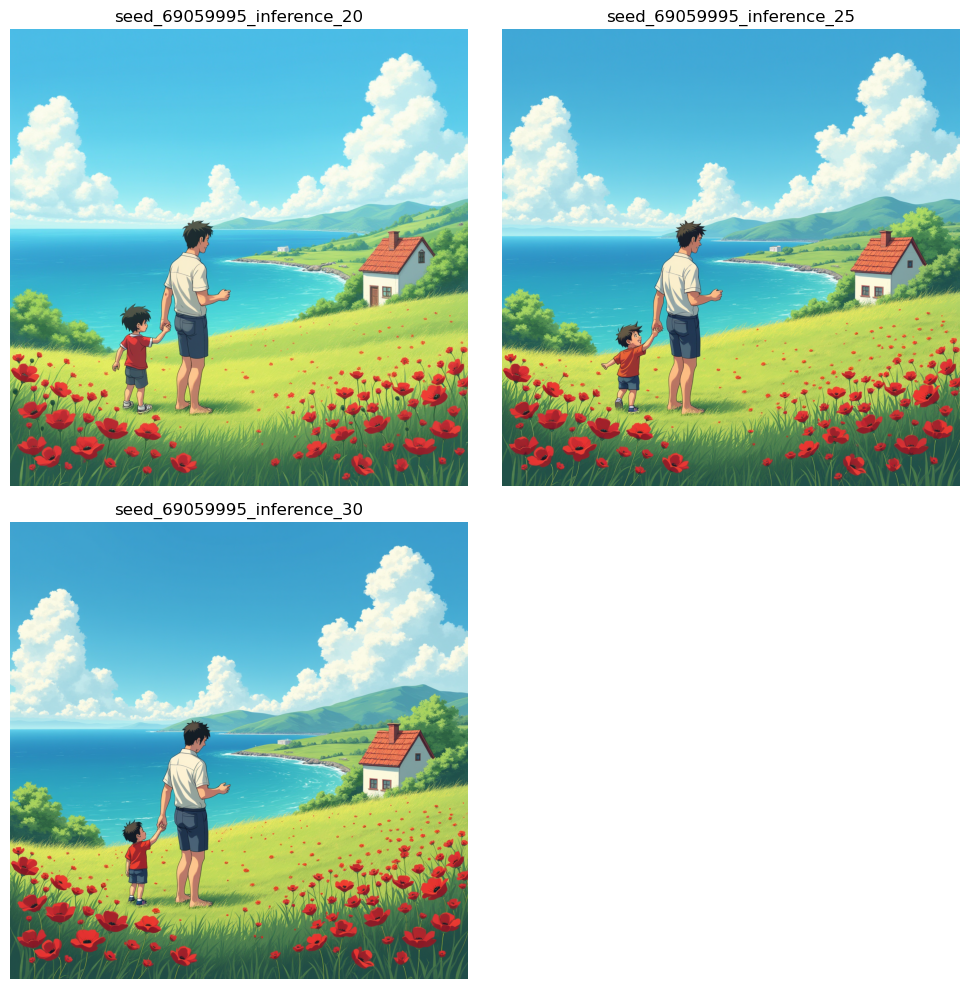

Mémoire libérée


In [10]:
# Étape 2 : Génération d'images avec différents inference steps
    # Sélectionner l'une des seeds générées parmis la liste
selected_seed = seeds[0] # ex: 1ère image sélectionnée
print('selected_seed:', selected_seed)

    # Sélectionner le nombre d'étapes d'inférence
        # More denoising steps usually lead to a higher quality image at the expense of slower inference.
inference_steps = [20, 25, 30] # inference_steps = [5, 10, 15, 20, 25, 30]

    # Générer les images
images = [generate_images(prompt, n_steps=n_steps, seed=selected_seed, width=1024, height=768)[0][0] for n_steps in inference_steps]
save_images(images, [f"seed_{selected_seed}_inference_{n_steps}" for n_steps in inference_steps], os.path.join(exploration_folder, "inference_steps_images"))
plot_images(images, [f"seed_{selected_seed}_inference_{n_steps}" for n_steps in inference_steps])
clear_memory()

selected_inference: 20


Generating images:   0%|                                                                         | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Generating images:   0%|                                                                         | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Generating images:   0%|                                                                         | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Generating images: 100%|███████████████████████████████████████████████████████████████| 1/1 [32:08<00:00, 1928.25s/it]


Image sauvegardée : E:\DATABASE\Images\20250117_183923\guidance_images\seed_69059995_steps_20_guidance_0.png
Image sauvegardée : E:\DATABASE\Images\20250117_183923\guidance_images\seed_69059995_steps_20_guidance_4.png
Image sauvegardée : E:\DATABASE\Images\20250117_183923\guidance_images\seed_69059995_steps_20_guidance_10.png
Nombre total d'images générées et sauvegardées : 3
Nombre approximatif de tokens dans le prompt : 36


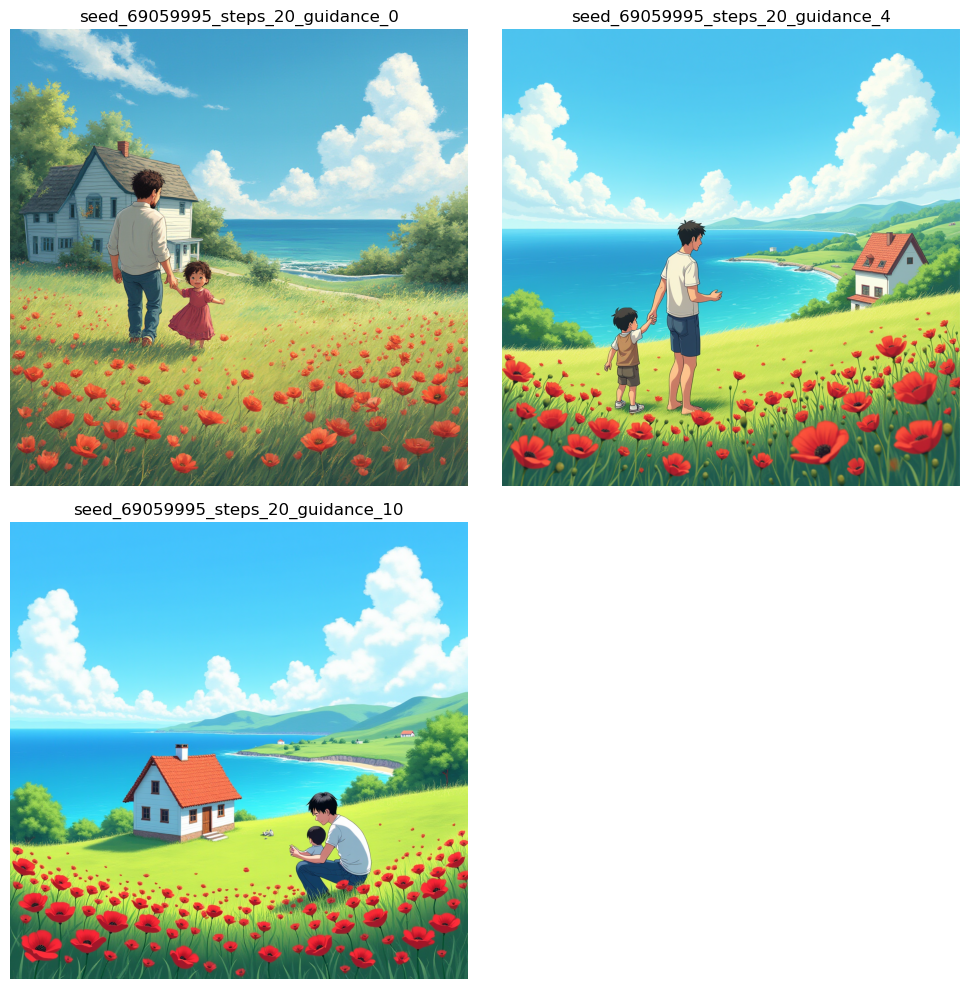

Mémoire libérée


In [11]:
# Étape 3 : Génération d'images avec différents guidance scales
    # Sélectionner l'une des seeds générées parmis la liste
selected_inference_steps = inference_steps[0] # ex: 1ère image sélectionnée
print('selected_inference:',selected_inference_steps)
    # Choisir l'échelle d'oriantation
        # Higher guidance scale encourages to generate images that are closely linked to the text prompt, usually at the expense of lower image quality
guidances = [0, 4, 10] #guidances = [0, 2, 4, 6, 8, 10]

    # Générer les images
images = [generate_images(prompt, guidance_scale=guidance, n_steps=selected_inference_steps, seed=selected_seed, width=1024, height=765)[0][0] for guidance in guidances]
save_images(images, [f"seed_{selected_seed}_steps_{selected_inference_steps}_guidance_{guidance}" for guidance in guidances], os.path.join(exploration_folder, "guidance_images"))
plot_images(images, [f"seed_{selected_seed}_steps_{selected_inference_steps}_guidance_{guidance}" for guidance in guidances])
clear_memory()